In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import sklearn
import nltk
import string

from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('PMChallenge2018/challenge2-train.txt', names=['label', 'text'], sep='\t')
df['label'].value_counts()

0    9197
1     994
Name: label, dtype: int64

In [3]:
exclude = set(string.punctuation)
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

# tolower, remove punctuation, stem words, and tokenize
def preproc(text):
    text = text.lower()
    text = ''.join(ch for ch in text if ch not in exclude)
    text = ps.stem(text)
    word_tokens = word_tokenize(text)
    filtered_sentence = [ps.stem(w) for w in word_tokens if not w in stop_words]
    return ' '.join(filtered_sentence)

In [4]:
# preprocess "text" column into "feature" column
df['feature'] = df['text'].apply(lambda x: preproc(x))
df.head(10)

,label,text,feature
0,0,Has Ben Carson started talking about hummus ye...,ben carson start talk hummu yet curiou find ha...
1,0,Christie: Obama created ISIS by not launching ...,christi obama creat isi launch war irangopdeb
2,1,"Trump is right, you can't fight everyone at th...",trump right cant fight everyon timethi dude ac...
3,0,#GOPDebate I'm somewhat amazed that I'm hearin...,gopdeb im somewhat amaz im hear someth resembl...
4,0,The ins and outs of the American Dream is unde...,in out american dream understood ricksantorum ...
5,0,So the #GOPDebate seems to be running on fear?...,gopdeb seem run fear got
6,0,Charlie sheen: did someone say winning? #GOPDe...,charli sheen someon say win gopdeb
7,0,I guess you might say Ted's mouth is on... Cru...,guess might say ted mouth cruz control gopdeb
8,0,"Since they lack central nervous systems, tuxed...",sinc lack central nervou system tuxedo cap rar...
9,1,"To be quite frank, Trump is right #GOPDebate",quit frank trump right gopdeb


In [5]:
# TF (no IDF) on "feature" column
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000, min_df=2, stop_words='english', use_idf=False)
t = vectorizer.fit(df['feature'])
X = t.transform(df['feature'])
#X = vectorizer.fit_transform(df['feature'])
y = np.array(df['label'])
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.33, random_state=432)

In [6]:
# simple logistic regression
lr = sklearn.linear_model.LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
metrics.auc(fpr, tpr)

0.74473802060008965

In [7]:
# SVM Classifier with linear kernel
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
metrics.auc(fpr, tpr)

0.84367816091954018

In [8]:
# Linear SVM Classifier
lsvc = sklearn.svm.LinearSVC()
lsvc.fit(X_train, y_train)
y_pred = lsvc.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
metrics.auc(fpr, tpr)

0.79795491864457391

In [9]:
# Gradient Boosted Tree
from sklearn import ensemble
gbc = sklearn.ensemble.GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
metrics.auc(fpr, tpr)

0.85333631885356032

Average AUC in 2 folds cross valudation: 0.9505368912650316


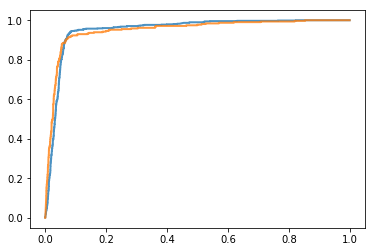

In [10]:
# 2 fold cross validation
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from scipy import interp
# Run classifier with cross-validation and plot ROC curves
n = 2
cv = KFold(n_splits=n)
#classifier = sklearn.ensemble.GradientBoostingClassifier()
classifier = sklearn.linear_model.LogisticRegression()
#classifier = sklearn.svm.SVC(probability=True, kernel='linear')

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.8, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
print ('Average AUC in {} folds cross valudation: {}'.format(n, np.average(aucs)))

In [11]:
# now train again on the entire set
m = classifier.fit(X, y)

In [22]:
# predict on the unlabeled set
df2 = pd.read_csv('PMChallenge2018/challenge2-unlabeledtestfile.txt', names=['label', 'text'], sep='\t')
df2['feature'] = df2['text'].apply(lambda x: preproc(x))
X2 = t.transform(df2['feature'])
df2['label'] = m.predict_proba(X2)[:,1]
df2.head(10)

,label,text,feature
0,0.832307,"It's TRUE how ppl cannot see it, they are all ...",true ppl see say thing trump said gopdeb trump...
1,0.030791,@JeffreyToobin please tell @wolfblitzer to KIL...,jeffreytoobin pleas tell wolfblitz kill microp...
2,0.022389,"If this debate was high school, I think I'd wa...",debat high school think id want ted cruz take ...
3,0.019604,War. Death. Fear. Killing. The only themes of ...,war death fear kill theme tonight gopdeb
4,0.052031,The Middle East hasn't been destabilized for t...,middl east hasnt destabil thousand year romeby...
5,0.026232,I like that the 80s gameshow buzzer on the GOP...,like 80 gameshow buzzer gop debat fit hope nex...
6,0.042035,Replace ISIS with ICEE. It'll be great. Everyo...,replac isi ice itll great everyon love trumpfo...
7,0.003068,#GOPDebate my favs tonight: Carly Fiorina and ...,gopdeb fav tonight carli fiorina rubioüòû rub...
8,0.054915,This is probably the sanest thing said about U...,probabl sanest thing said us foreign polici to...
9,0.039544,Who the fuck is this guy? #GOPDebate,fuck guy gopdeb


In [24]:
df2['label'].to_csv('PMChallenge2018/challenge2-score.txt', index=False)